# FOREX Regression modelling using SARIMA models

In this notebook, EUR-USD currency pair price prediction using SARIMA models will be studied. Both univariate and multivariate (using technical indicators) models will be considered. The data used in this study is daily data extracted from `Yahoo Finance`.  

Here is the Table of contents:

[I. Data](#I.-Data)<br>
[II. Stationarity](#II.-Stationarity)<br>
[III. SARIMA- Univariate](#III.-SARIMA--Univariate)<br>
[IV. SARIMA- Multivariate](#IV.-SARIMA--Multivariate)<br>
[V. Performance Comparison](#V.-Performance-Comparison)

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.api import tsa 
import statsmodels.api as sm
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import seaborn as sns
import pmdarima as pm
import talib

## I. Data

Let's load the daily data take a look at it:

In [2]:
df = pd.read_csv("data\EURUSD_daily.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-05-02,1.286207,1.287498,1.284208,1.284604,1.284604,0.0
1,2005-05-03,1.284901,1.290006,1.283302,1.288693,1.288693,0.0
2,2005-05-04,1.288693,1.297202,1.287896,1.295001,1.295001,0.0
3,2005-05-05,1.295001,1.298701,1.293193,1.295605,1.295605,0.0
4,2005-05-06,1.295505,1.296395,1.281099,1.281197,1.281197,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3913 entries, 0 to 3912
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3913 non-null   object 
 1   Open       3885 non-null   float64
 2   High       3885 non-null   float64
 3   Low        3885 non-null   float64
 4   Close      3885 non-null   float64
 5   Adj Close  3885 non-null   float64
 6   Volume     3885 non-null   float64
dtypes: float64(6), object(1)
memory usage: 214.1+ KB


In [19]:
# Missing values
df.isna().sum()

Open         28
High         28
Low          28
Close        28
Adj Close    28
dtype: int64

In [4]:
# Change the index format to datetime
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [5]:
# Check
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2005-05-02,2005-05-02,1.286207,1.287498,1.284208,1.284604,1.284604,0.0
2005-05-03,2005-05-03,1.284901,1.290006,1.283302,1.288693,1.288693,0.0
2005-05-04,2005-05-04,1.288693,1.297202,1.287896,1.295001,1.295001,0.0
2005-05-05,2005-05-05,1.295001,1.298701,1.293193,1.295605,1.295605,0.0
2005-05-06,2005-05-06,1.295505,1.296395,1.281099,1.281197,1.281197,0.0


The `Date` and `Volume` columns will be dropped since there is no extra information in them.

In [6]:
# Dropping Date and Volume columns
df.drop(columns=['Date', 'Volume'], inplace=True)

In [7]:
# Check
df.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2005-05-02,1.286207,1.287498,1.284208,1.284604,1.284604
2005-05-03,1.284901,1.290006,1.283302,1.288693,1.288693
2005-05-04,1.288693,1.297202,1.287896,1.295001,1.295001
2005-05-05,1.295001,1.298701,1.293193,1.295605,1.295605
2005-05-06,1.295505,1.296395,1.281099,1.281197,1.281197


As for statistical modelling using ARIMA approaches, there shouldn't be any missing timestamp in the data, the full range will be generated and the missing timestamps will be filled. 

In [9]:
# Getting the first day and last day of the df
first_day = df.index.min()
last_day = df.index.max()

In [10]:
# Getting the number of timestamps in the full range
full_range = pd.date_range(first_day, last_day, freq='D')
full_range.shape[0]

5477

In [11]:
# Total number of missing timestamps
differences = full_range.difference(df.index)
differences.shape

(1564,)

In [12]:
# Check the day names of the missing days 
day_names_missed = differences.day_name()
day_names_missed.value_counts()

Saturday    782
Sunday      782
Name: count, dtype: int64

In [16]:
# Checking the day names of the timestamps in the df
day_names_total = df.index.day_name()
day_names_total.value_counts()

Date
Monday       783
Tuesday      783
Wednesday    783
Thursday     782
Friday       782
Name: count, dtype: int64

As can be seen there is no timestamps missing in the week days and only weekends are missing. It is normal since FOREX is 24/5.

The missing weekends and any missing values in the df will be filled with the forward filling approach.

In [20]:
# Filling missing values
df_comp = df.fillna(method='ffill')

In [23]:
# Check
df_comp.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
dtype: int64

Data is now ready for the modelling part.

### Data for the modelling part

In [27]:
# Check the data
df_comp.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2005-05-02,1.286207,1.287498,1.284208,1.284604,1.284604
2005-05-03,1.284901,1.290006,1.283302,1.288693,1.288693
2005-05-04,1.288693,1.297202,1.287896,1.295001,1.295001
2005-05-05,1.295001,1.298701,1.293193,1.295605,1.295605
2005-05-06,1.295505,1.296395,1.281099,1.281197,1.281197


In [28]:
start_date = '2015-01-01'
end_date = '2020-01-01'
df_model = df_comp[(df_comp.index >= start_date) & (df_comp.index < end_date)]
df_model.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2015-01-01,1.209863,1.209863,1.209863,1.209863,1.209863
2015-01-02,1.208868,1.208956,1.201080,1.208941,1.208941
2015-01-05,1.195500,1.197590,1.188909,1.194643,1.194643
2015-01-06,1.193830,1.197000,1.188693,1.193902,1.193902
2015-01-07,1.187479,1.190000,1.180401,1.187536,1.187536


While different approaches are available for selecting the target variable, the `Close` price will be used for the modelling part in this study.

In [29]:
# Selecting the target column
df_model = df_model['Close'].to_frame()

In [30]:
# Check
df_model.head()

,Close
Date,
2015-01-01,1.209863
2015-01-02,1.208941
2015-01-05,1.194643
2015-01-06,1.193902
2015-01-07,1.187536


## II. Stationarity

The stationarity of the data will be studied based on the visual and two statistical tests: ADF and KPSS.

Let's see how the data looks when decomposed.

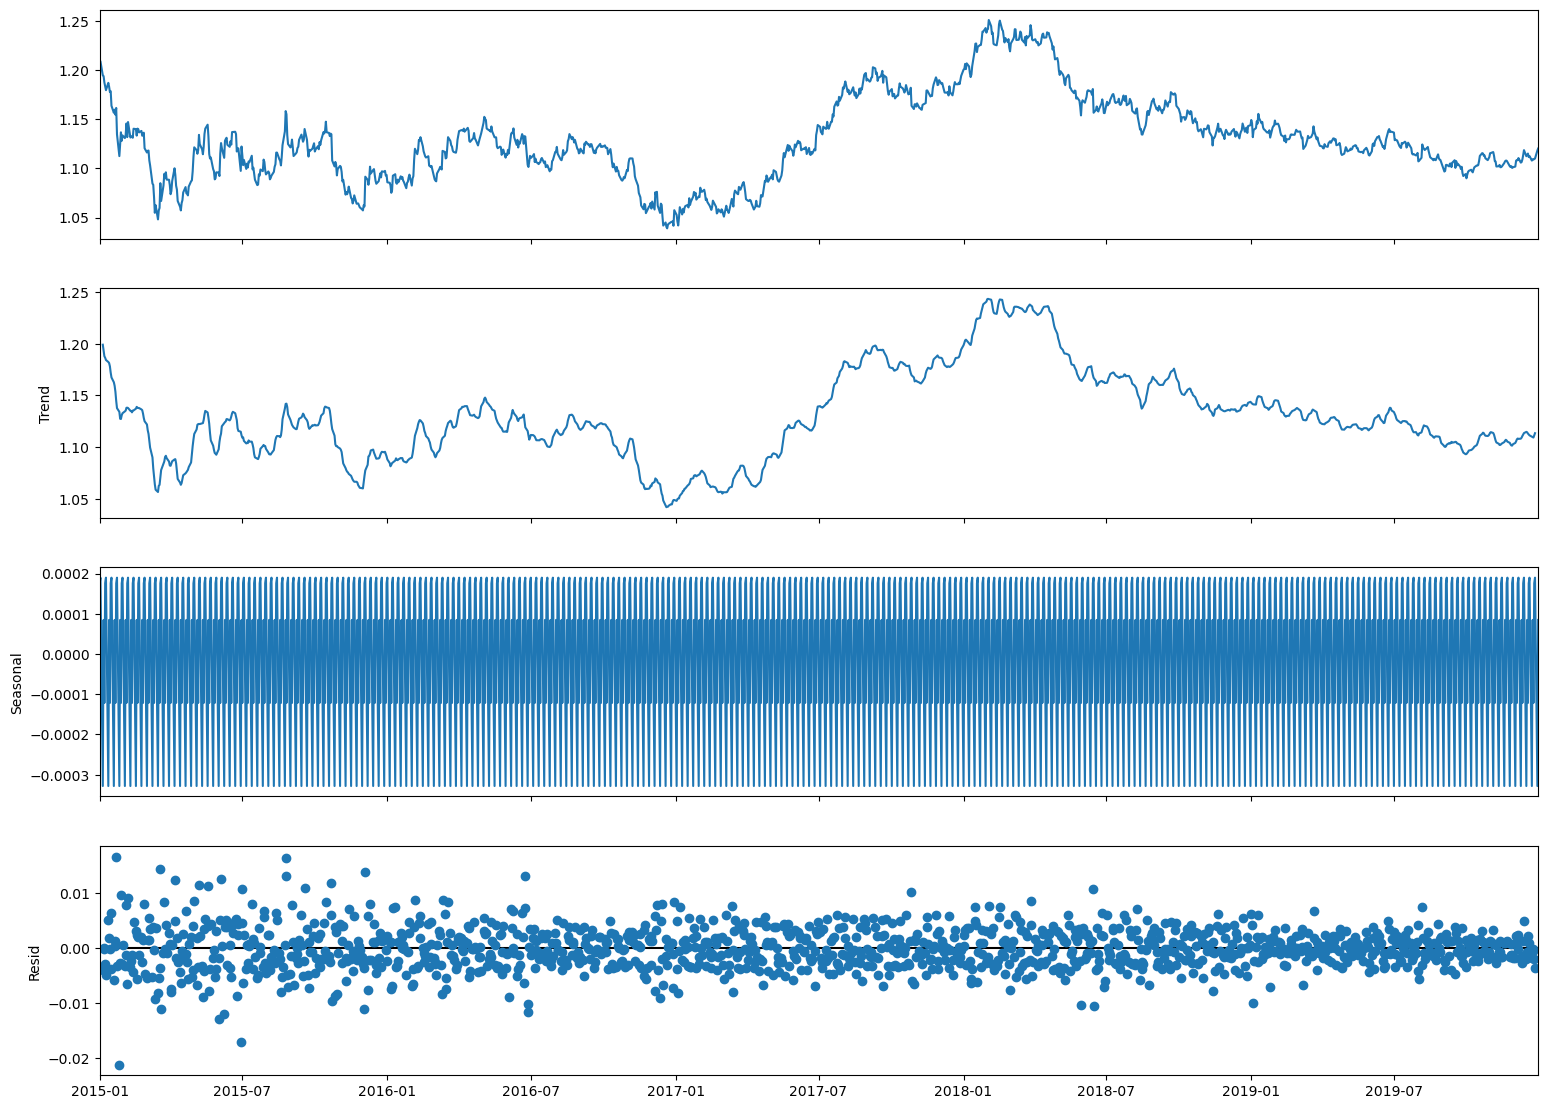

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed_data = seasonal_decompose(df_model, model="additive")
fig = decomposed_data.plot()
fig.set_size_inches(18,12)

From the decomposition it can be found that the data is too noisy and not stationary since the trend shows increasing and decreasing behavior.

The decomposition plots can also be plotted with plotly.

In [41]:
df_plotly = df_model.copy()

In [42]:
decomposition = tsa.seasonal_decompose(df_plotly['Close'], model='additive')

In [43]:
# Add the decomposition data

df_plotly["Trend"] = decomposition.trend
df_plotly["Seasonal"] = decomposition.seasonal
df_plotly["Residual"] = decomposition.resid

df_plotly.head(10)

,Close,Trend,Seasonal,Residual
Date,,,,
2015-01-01,1.209863,NaN,0.000176,NaN
2015-01-02,1.208941,NaN,0.000190,NaN
2015-01-05,1.194643,1.198977,-0.000328,-0.004006
2015-01-06,1.193902,1.193724,0.000085,0.000093
2015-01-07,1.187536,1.187858,-0.000122,-0.000200
2015-01-08,1.183600,1.186343,0.000176,-0.002919
2015-01-09,1.179607,1.184193,0.000190,-0.004776
2015-01-12,1.187070,1.182252,-0.000328,0.005147
2015-01-13,1.183152,1.181250,0.000085,0.001817


In [44]:
cols = ["Trend", "Seasonal", "Residual"]

fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=df_plotly.index, y=df_plotly[col]),
        row=i+1,
        col=1
    )

fig.update_layout(height=1000, width=1500, showlegend=False)
fig.show()

Now, the ACF and PACF plots will be investigated.

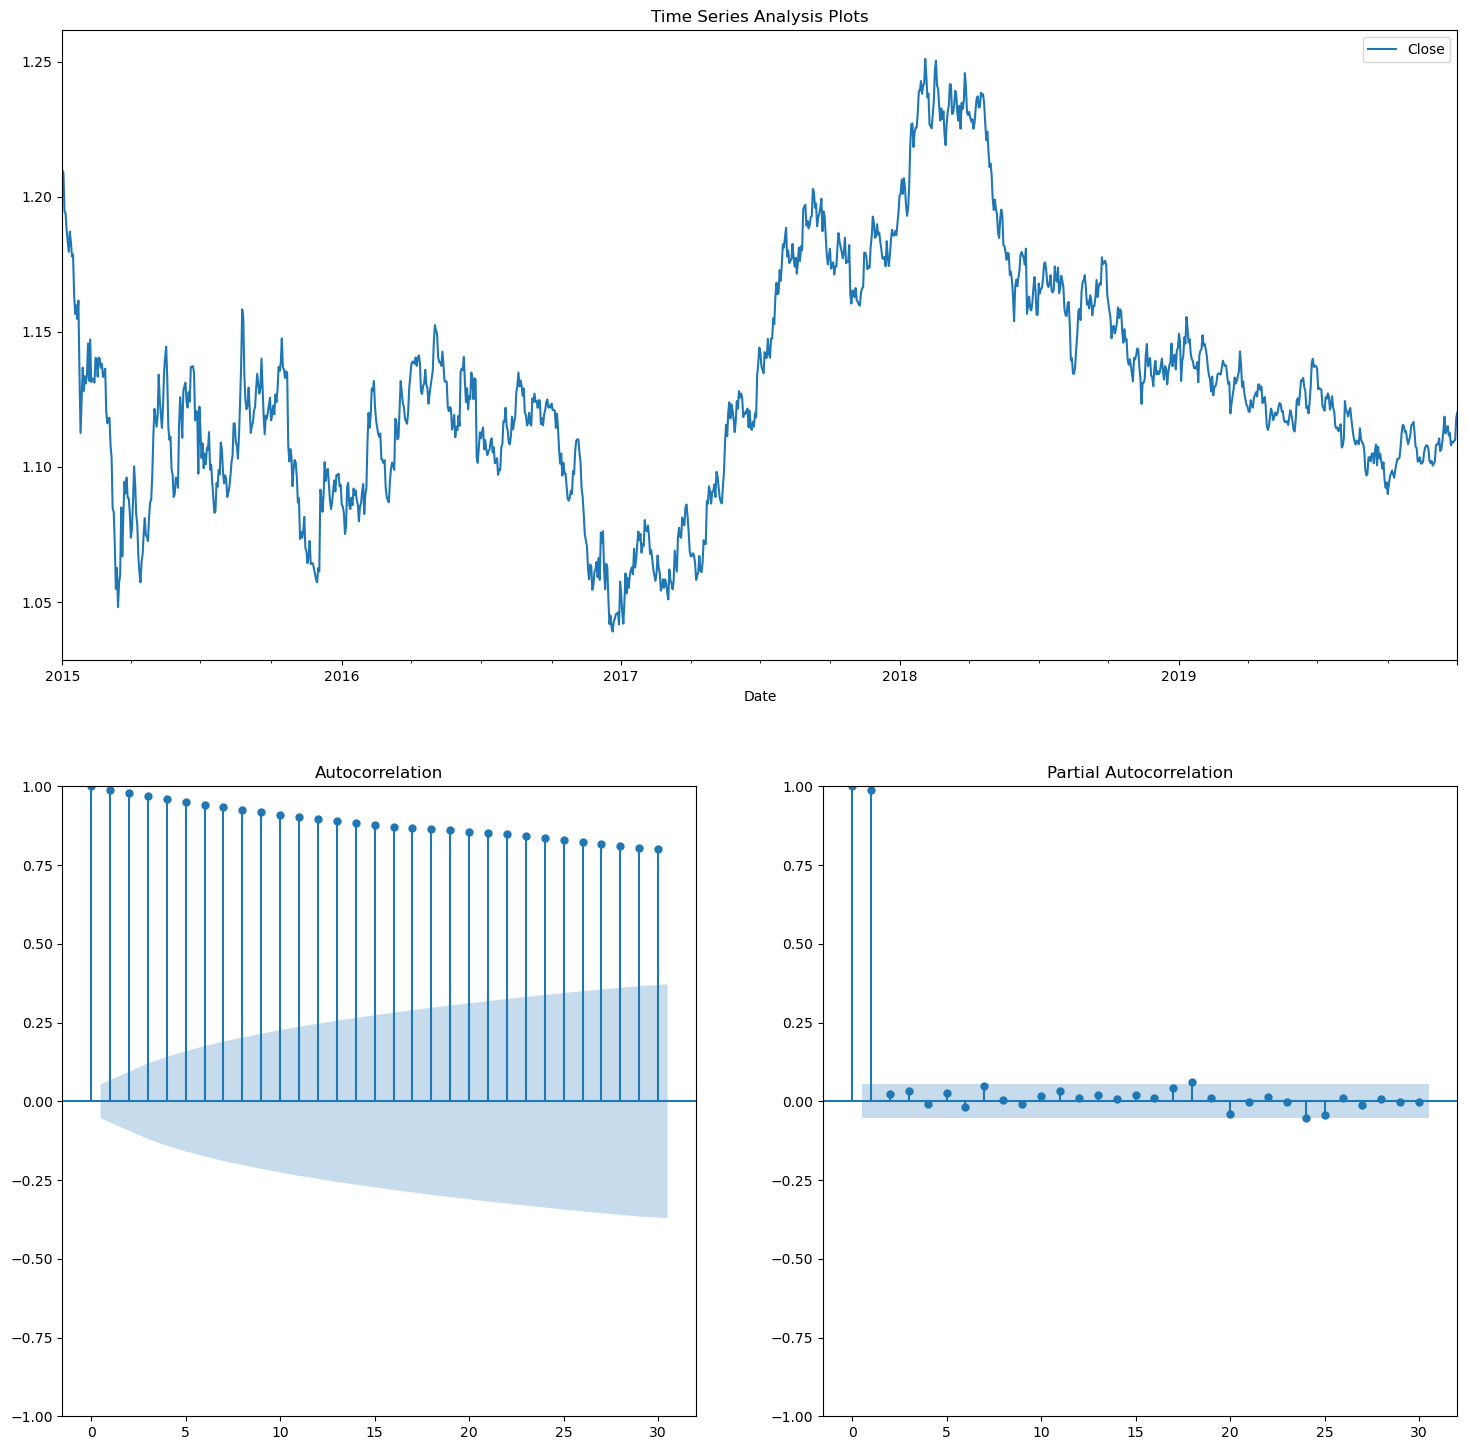

In [34]:
fig = plt.figure(figsize=(18,18))
layout = (2,2)
ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
ts_ax.set_title('Time Series Analysis Plots')
acf_ax = plt.subplot2grid(layout, (1,0))
pacf_ax = plt.subplot2grid(layout, (1,1))
df_model.plot(ax=ts_ax)
sm.graphics.tsa.plot_acf(df_model.values.squeeze(), lags=30, ax=acf_ax)
sm.graphics.tsa.plot_pacf(df_model.values.squeeze(), lags=30, ax=pacf_ax, method='ywm')
plt.show()

From the ACF it can be seen that it has slow-decaying characteristic implying that the data is not stationary.

### ADF and KPSS tests for stationarity
**ADF test**:

ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:

<center>Null Hypothesis: The series has a unit root (series is not stationary).</center>

<center>Alternate Hypothesis: The series has no unit root (series is stationary).</center>

**KPSS test**:

KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.


<center>Null Hypothesis: The process is trend stationary.</center>

<center>Alternate Hypothesis: The series has a unit root (series is not stationary).</center>


It is always better to apply both the tests, so that it can be ensured that the series is truly stationary. Possible outcomes of applying these stationary tests are as follows:

Case 1: Both tests conclude that the series is not stationary - The series is not stationary

Case 2: Both tests conclude that the series is stationary - The series is stationary

Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.

Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

ADF test: 0.054222929747321263 
KPSS test: 0.01
Time series is not stationary and differencing is required
ADF test after differencing: 0.0 
KPSS test after differencing: 0.1


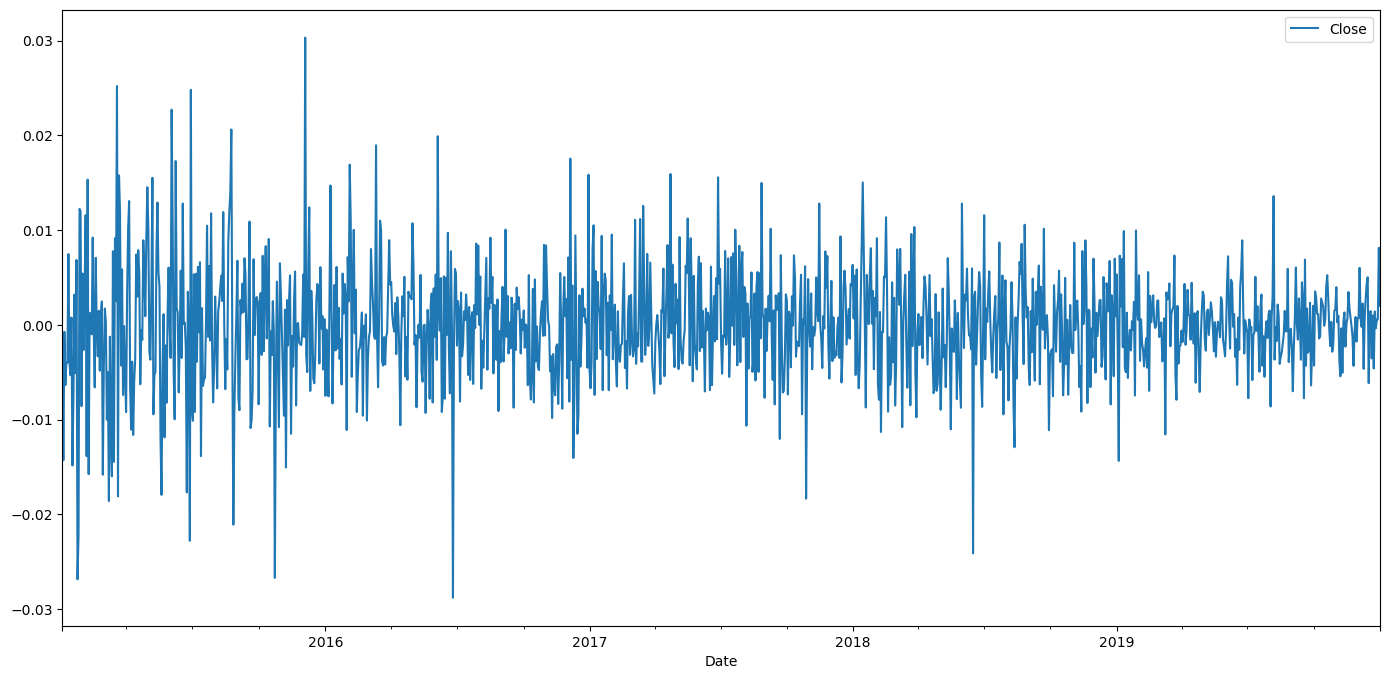

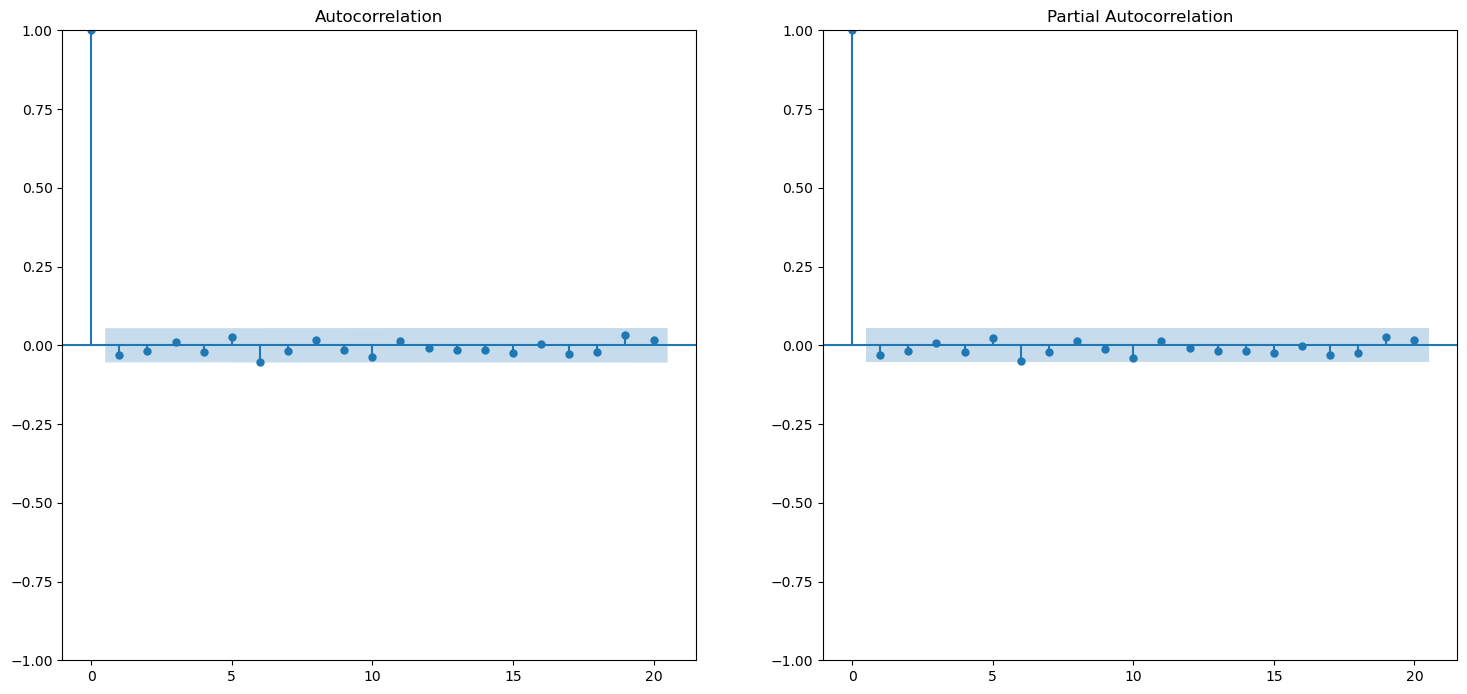

In [36]:
# Checking the statinarity with the tests
import warnings
warnings.filterwarnings("ignore")

p_value=[]
p_value.append(sm.tsa.stattools.adfuller(df_model)[1])
p_value.append(sm.tsa.stattools.kpss(df_model)[1])
print(f"ADF test: {p_value[0]} \nKPSS test: {p_value[1]}" )
if (p_value[0]<0.05) & (p_value[1]>0.05):
    print("Time series is stationary and there is no need for differencing.")

if (p_value[0]>0.05) & (p_value[1]<0.05):
    # ACF and PACF of the first differenciated data
    print("Time series is not stationary and differencing is required")
    from statsmodels.tsa.statespace.tools import diff
    first_diff = df_model.diff()[1:] 
    p_value.append(sm.tsa.stattools.adfuller(first_diff)[1])
    p_value.append(sm.tsa.stattools.kpss(first_diff)[1])
    print(f"ADF test after differencing: {p_value[2]} \nKPSS test after differencing: {p_value[3]}")
    first_diff.plot(figsize=(17,8))
    fig = plt.figure(figsize=(18,18))
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))
    sm.graphics.tsa.plot_acf(first_diff.values.squeeze(), lags=30,ax=acf_ax)
    sm.graphics.tsa.plot_pacf(first_diff.values.squeeze(), lags=30, method='ywm',ax=pacf_ax)
    

From the tests, it was shown that the time series is not stationary and differencing is required. The differenced series shows stationarity and the ACF and PACF plots do not show any trend or seasonality. 

## III. SARIMA- Univariate

### Data splitting


In [62]:
nobs = len(df_model)
n_init_training = int(nobs * 0.8)
df_model_training = df_model[:n_init_training]
df_model_test = df_model[n_init_training:]

### Obtain the best SARIMA model parameters

From the `auto_arima` function, the best parameters of the SARIMA can be found.

In [125]:
def model_arima(data):
    automodel = pm.auto_arima(data, start_p=0, start_q=0, max_p=10, max_q=10, d=None,
                              start_P=0, start_Q=0, D=None, max_P=10, max_Q=10, m=7, seasonal=True, trace=True)
    return automodel

Mdl = model_arima(df_model_training)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-7578.044, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-7575.375, Time=0.50 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-7575.432, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-7579.940, Time=0.12 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-7576.340, Time=0.20 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-7576.352, Time=0.31 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=-7574.361, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-7577.059, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-7577.104, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=-7575.357, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 2.938 seconds


In [126]:
Mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1043
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3790.970
Date:                Sun, 25 Jun 2023   AIC                          -7579.940
Time:                        19:18:11   BIC                          -7574.992
Sample:                    01-01-2015   HQIC                         -7578.063
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.046e-05   1.22e-06     33.119      0.000    3.81e-05    4.29e-05
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):               210.61
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [127]:
order = Mdl.order
seasonal_order = Mdl.seasonal_order
print(f"Non-seasonal order: {order} \nSeasonal order: {seasonal_order}")

Non-seasonal order: (0, 1, 0) 
Seasonal order: (0, 0, 0, 7)


In [128]:
# Train the model with the best parameters found by auto_arima
Mdl = sm.tsa.SARIMAX(df_model_training, order=order, scoring_args={}, seasonal_order=seasonal_order, suppress_warnings=True)
res = Mdl.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1043
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3790.970
Date:                Sun, 25 Jun 2023   AIC                          -7579.940
Time:                        19:18:21   BIC                          -7574.992
Sample:                    01-01-2015   HQIC                         -7578.063
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.046e-05   1.22e-06     33.119      0.000    3.81e-05    4.29e-05
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):               210.61
Prob(Q):                              0.31   Pr

From the results it can be indicated the suggested non-seasonal order is (0, 1, 0), indicating that there is no significant autoregressive or moving average component present in the time series after differencing. Also, the suggested seasonal order is (0, 0, 0, 7), indicating that there is no significant seasonal component present in the time series. Overall, it can be concluded that the SARIMA model can not be a good fit for the FOREX complex data.

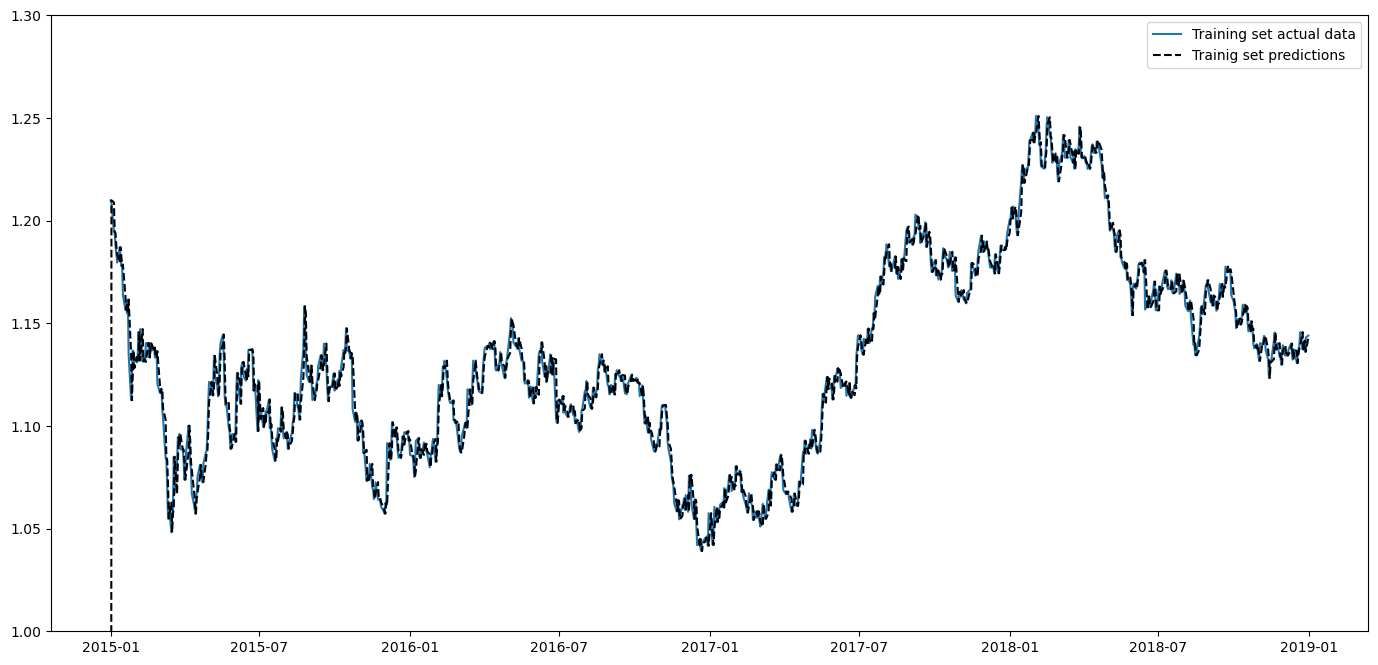

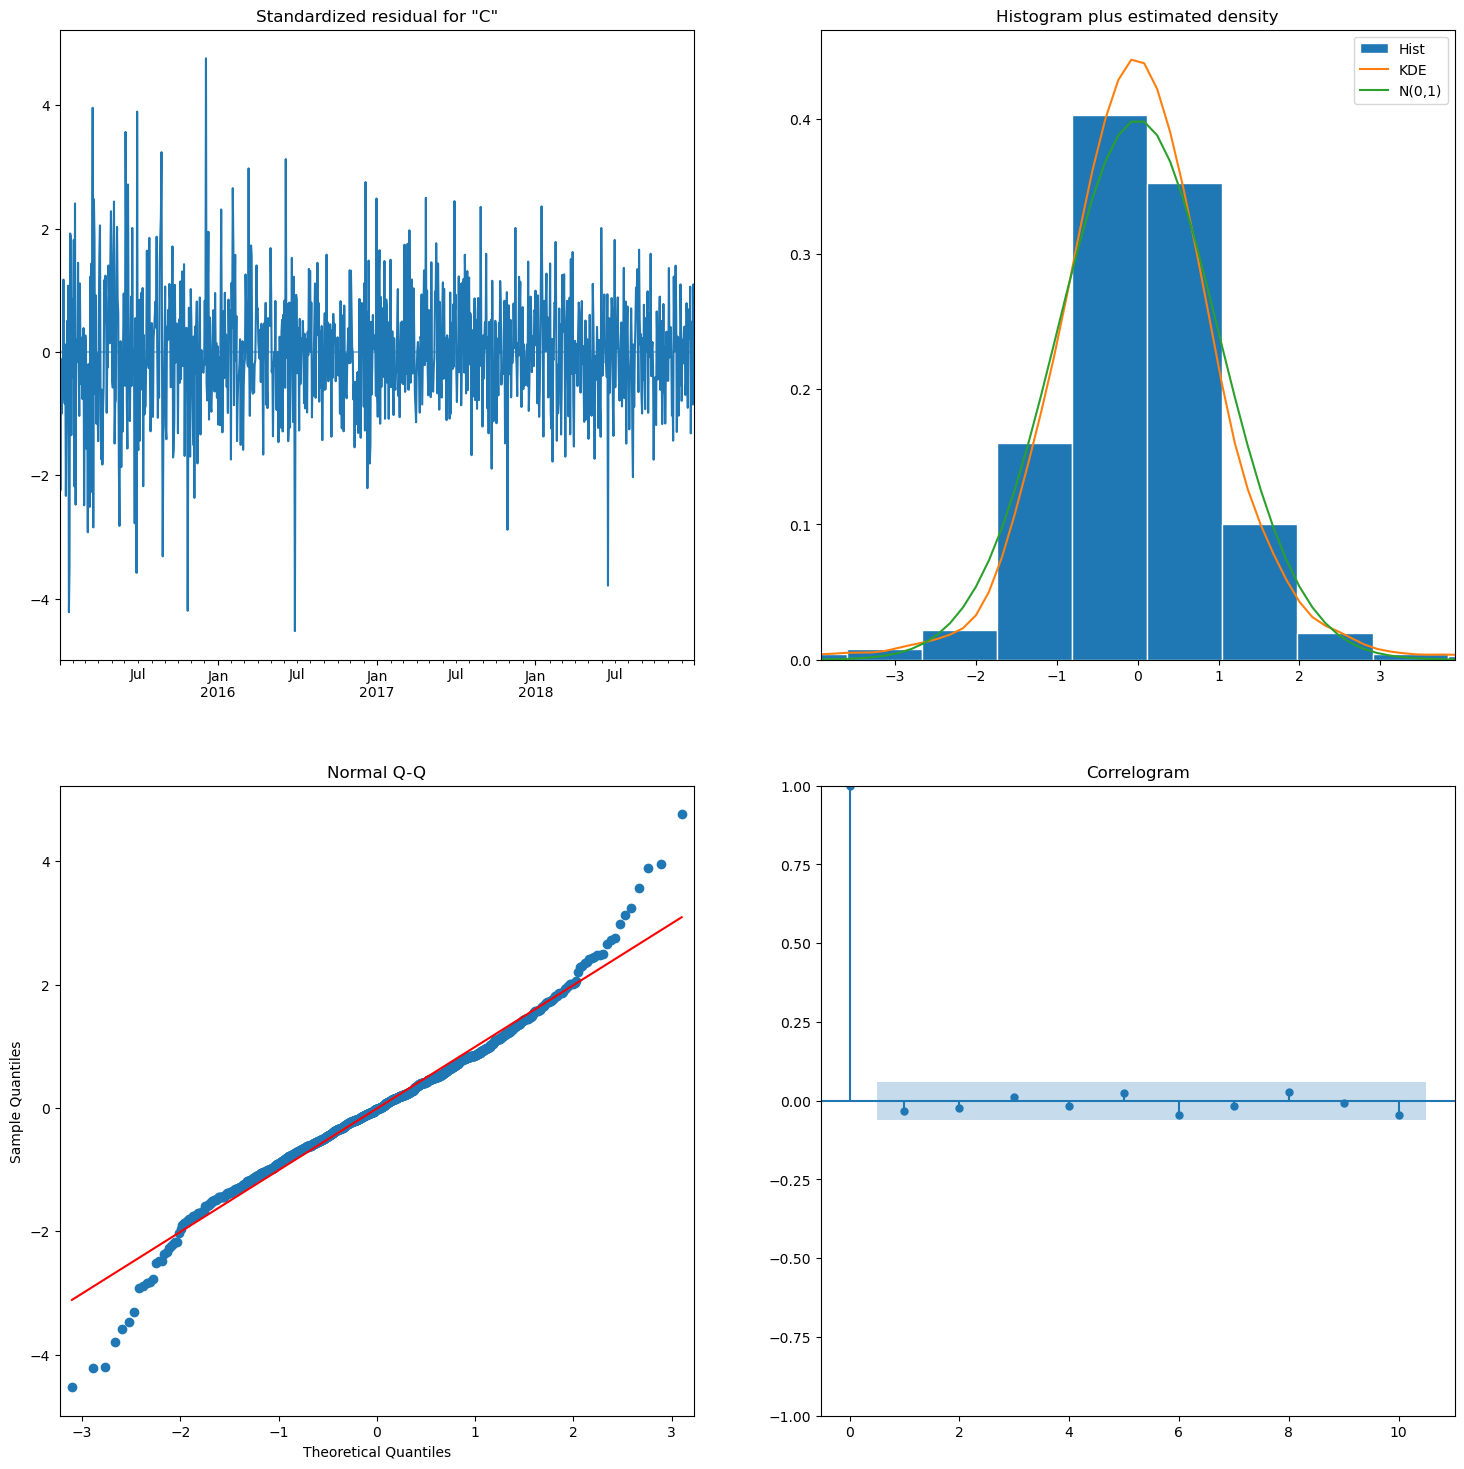

In [129]:
# Getting the training predictions
pred_training = res.predict(start=0,end=n_init_training-1)
pred_training.head()
pred_training.index = df_model[:n_init_training].index
plt.figure(figsize=(17,8))
plt.plot(df_model[:n_init_training], label='Training set actual data')
plt.plot(pred_training, 'k--', label='Trainig set predictions')
#plt.xlabel(x_var)
#plt.ylabel(y_var)
plt.ylim(1,1.3)
plt.legend(loc='best')
plt.show()
fig = res.plot_diagnostics()
fig.set_size_inches(18,18)

From the training prediction plot it can be observed that the predicttions follow the same behavior of the actual data with a lag. It was predictible since the model is just a differentiation of the actual data.

### Forecast on the test set

Let's get the forecasts on the test set.

There are two approaches to get the forecasts for the test set. In the first approach, the model will predict n steps ahead (length of the test set) in one shot, meaning that it wil use it's own predictions for the next forecasts. 

In the next approach, based on the number of horizons to predict, the model will n horizons in the future, then the actual value of the present timestamp will be added to the model for the forecast of the next n horizons. This method is more accurate but it take more time to compute for the whole test test especially in big datasets.

#### Approach 1:

In [130]:
test_predictions_1 = res.predict(start=n_init_training, end=nobs-1)

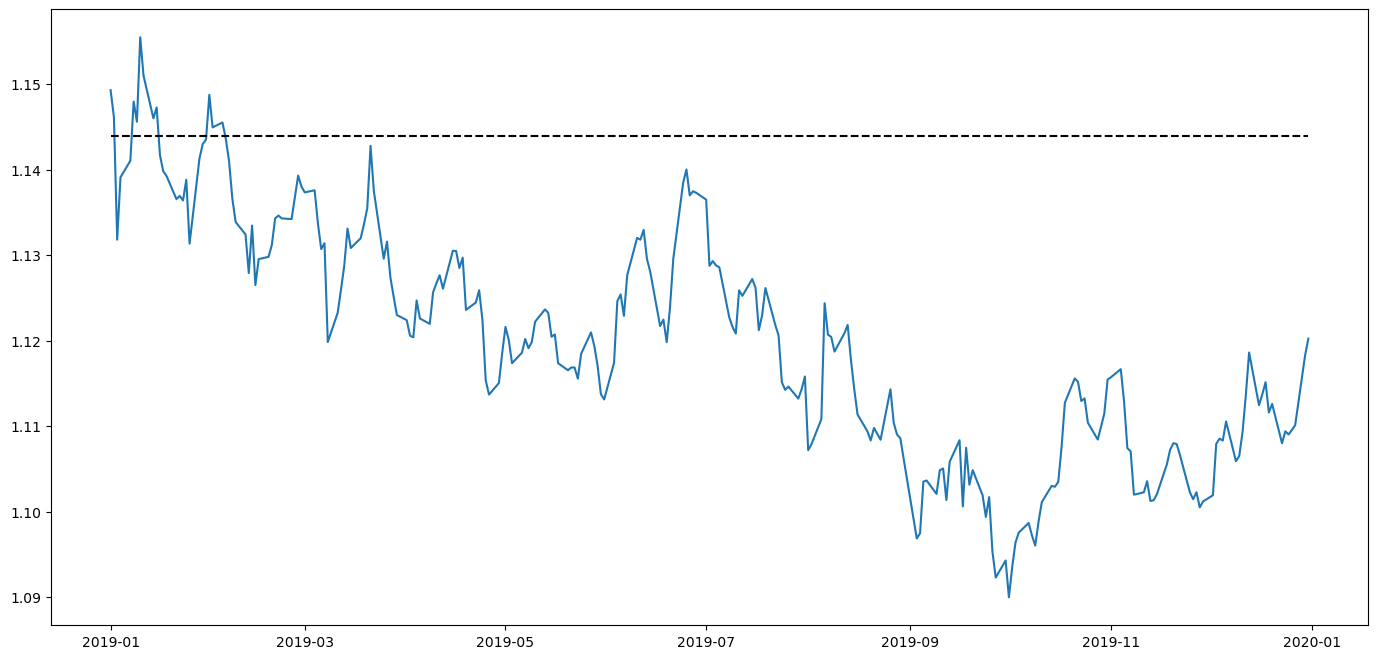

In [131]:
plt.figure(figsize=(17,8))
plt.plot(df_model_test['Close'], label=f'Test set actual data')
plt.plot(test_predictions_1, 'k--', label=f'Test set predictions')
plt.show()

As seen in the figure above, the predictions are constant value of the last closing price of the training set. This was expected, since the model is just using the previous value for the prediction based on the model orders.

Let's try the next approach:

#### Approach 2:

This time each time that one time step ahead is predicted the actual value of the present time stamp will be added to the model for the next prediction.

In [70]:
# Setup forecasts
nforecasts = 1
forecasts = {}

# Save initial forecast
forecasts[df_model_training.index[-1]] = res.forecast(steps=nforecasts)

# Step through the rest of the sample
for t in range(n_init_training, nobs):
    # Update the results by appending the next observation
    updated_df_model = df_model.iloc[t:t+1]
    res = res.append(updated_df_model, refit=False)
    
    # Save the new set of forecasts
    forecasts[updated_df_model.index[0]] = res.forecast(steps=nforecasts)

# Combine all forecasts into a dataframe
forecasts = pd.concat(forecasts, axis=1)

print(forecasts.iloc[:5, :5])

            2018-12-31  2019-01-01  2019-01-02  2019-01-03  2019-01-04
2019-01-01    1.143995         NaN         NaN         NaN         NaN
2019-01-02         NaN    1.149306         NaN         NaN         NaN
2019-01-03         NaN         NaN    1.146171         NaN         NaN
2019-01-04         NaN         NaN         NaN    1.131811         NaN
2019-01-07         NaN         NaN         NaN         NaN    1.139108


In [88]:
# Construct the forecast errors
forecast_errors = forecasts.apply(lambda column: df_model['Close'] - column).reindex(forecasts.index)

print(forecast_errors.iloc[:5, :5])

            2018-12-31  2019-01-01  2019-01-02  2019-01-03  2019-01-04
2019-01-01    0.005311         NaN         NaN         NaN         NaN
2019-01-02         NaN   -0.003135         NaN         NaN         NaN
2019-01-03         NaN         NaN    -0.01436         NaN         NaN
2019-01-04         NaN         NaN         NaN    0.007297         NaN
2019-01-07         NaN         NaN         NaN         NaN    0.001936


In [89]:
# Reindex the forecasts by horizon rather than by date
def flatten(column):
    return column.dropna().reset_index(drop=True)

flattened = forecast_errors.apply(flatten)
flattened.index = (flattened.index + 1).rename('horizon')

print(flattened.iloc[:3, :5])

         2018-12-31  2019-01-01  2019-01-02  2019-01-03  2019-01-04
horizon                                                            
1          0.005311   -0.003135    -0.01436    0.007297    0.001936


In [90]:
# Compute the root mean square error
rmse = (flattened**2).mean(axis=1)**0.5
print(rmse)

horizon
1    0.003616
dtype: float64


In [91]:
flattened_forecast = forecasts.apply(flatten)
flattened_forecast

,2018-12-31,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,...,2019-12-18,2019-12-19,2019-12-20,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-30,2019-12-31
0,1.143995,1.149306,1.146171,1.131811,1.139108,1.141044,1.147974,1.145607,1.155495,1.151013,...,1.115138,1.111593,1.112595,1.107984,1.109385,1.109016,1.109545,1.110112,1.11823,1.12023


In [92]:
# To get the forecasts in a standard format
pred_test = flattened_forecast.loc[0,:]
pred_test

2018-12-31    1.143995
2019-01-01    1.149306
2019-01-02    1.146171
2019-01-03    1.131811
2019-01-04    1.139108
                ...   
2019-12-25    1.109016
2019-12-26    1.109545
2019-12-27    1.110112
2019-12-30    1.118230
2019-12-31    1.120230
Name: 0, Length: 262, dtype: float64

In [93]:
# To remove the last prediction since it would be out of the range of the test data
test_predictions_2 = pred_test[:-1]

In [94]:
# Make the index of the predictions same as the actual test set for comparison
test_predictions_2.index = df_model[n_init_training:].index

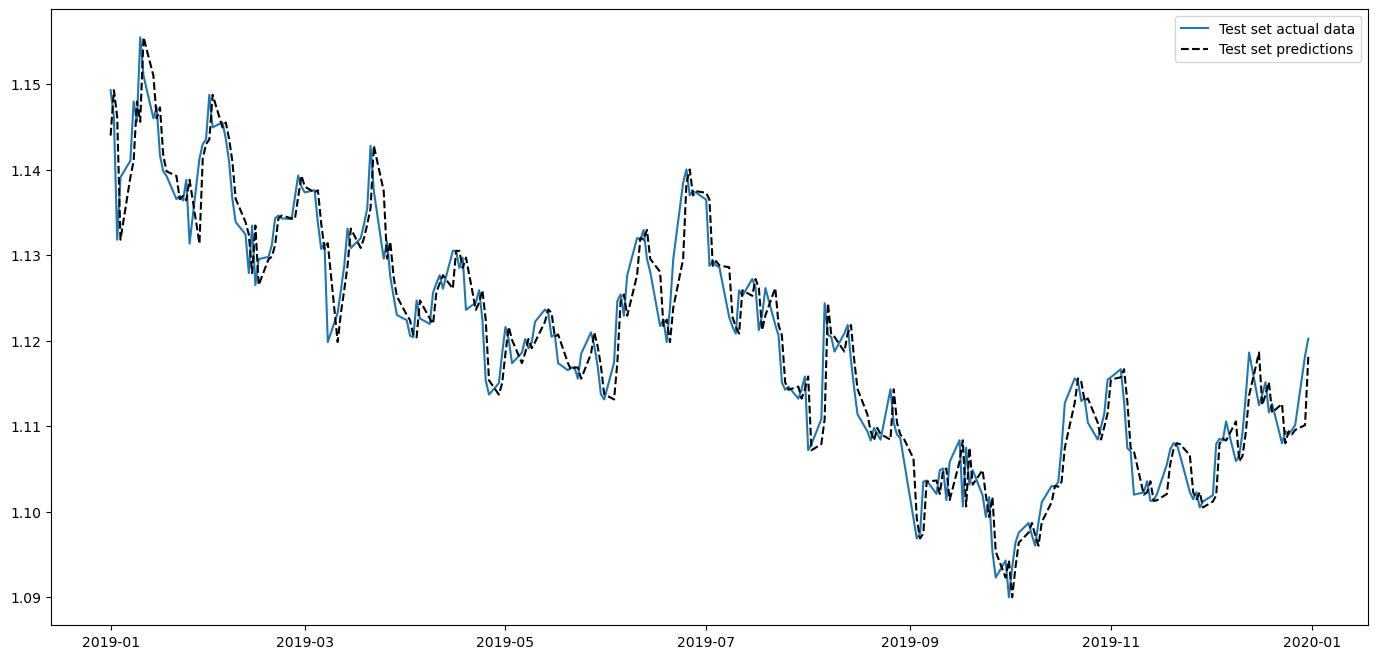

In [147]:
# Plot the test forecasts
plt.figure(figsize=(17,8))
plt.plot(df_model[n_init_training:], label=f'Test set actual data')
plt.plot(test_predictions_2, 'k--', label=f'Test set predictions')
plt.legend()
plt.show()

It can be seen that this time the predictions are following exactly the actual data but with a lag which is coming from the differencing. In the next part the multivariate time series will be investigated to see if this delay behavior can be improved or not.

## IV. SARIMA- Multivariate

Multivariate time series analysis involves the analysis of data over time that consists of multiple interdependent variables. In this study, the technical indicators will be studied.

In [97]:
# Getting the data for Multivariate Model
df_mm = df_model.copy()

In [98]:
# Check
df_mm

,Close
Date,
2015-01-01,1.209863
2015-01-02,1.208941
2015-01-05,1.194643
2015-01-06,1.193902
2015-01-07,1.187536
...,...
2019-12-25,1.109016
2019-12-26,1.109545
2019-12-27,1.110112


While there are numerous technical indicators, choosing them is arbitrary and based on the perfromance of the model. For this study the following technical indicators will be considered:

- Moving Average (MA):

MA_10: 10-day Simple Moving Average (SMA) of the closing prices.<br>
MA_50: 50-day Simple Moving Average (SMA) of the closing prices.

- Relative Strength Index (RSI):

RSI: 14-day Relative Strength Index, a momentum oscillator that measures the speed and change of price movements.

- Bollinger Bands (BB):

BB_upper: Upper Bollinger Band, representing the standard deviation above the middle band.<br>
BB_middle: Middle Bollinger Band, typically a Simple Moving Average (SMA) of the closing prices.<br>
BB_lower: Lower Bollinger Band, representing the standard deviation below the middle band.

- Moving Average Convergence Divergence (MACD):

MACD: Moving Average Convergence Divergence, the difference between the 12-day Exponential Moving Average (EMA) and the 26-day EMA.<br>
MACD_Signal: 9-day EMA of the MACD line, often used as a trigger line.<br>
MACD_Hist: Histogram of the MACD, showing the difference between the MACD line and the signal line.

These indicators provide insights into price trends, momentum, volatility, and potential buy/sell signals in the financial markets.

The mentioned indicators will be imported from `talib`:

In [100]:
# Calculate moving averages (MA)
df_mm['MA_10'] = talib.SMA(df_mm['Close'], timeperiod=10)
df_mm['MA_50'] = talib.SMA(df_mm['Close'], timeperiod=50)

# Calculate Relative Strength Index (RSI)
df_mm['RSI'] = talib.RSI(df_mm['Close'], timeperiod=14)

# Calculate Bollinger Bands (BB)
upper_band, middle_band, lower_band = talib.BBANDS(df_mm['Close'], timeperiod=20)
df_mm['BB_upper'] = upper_band
df_mm['BB_middle'] = middle_band
df_mm['BB_lower'] = lower_band

# Calculate Moving Average Convergence Divergence (MACD)
macd, macd_signal, macd_hist = talib.MACD(df_mm['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df_mm['MACD'] = macd
df_mm['MACD_Signal'] = macd_signal
df_mm['MACD_Hist'] = macd_hist

In [101]:
# Check
df_mm.head()

,Close,MA_10,MA_50,RSI,BB_upper,BB_middle,BB_lower,MACD,MACD_Signal,MACD_Hist
Date,,,,,,,,,,
2015-01-01,1.209863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,1.208941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,1.194643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,1.193902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,1.187536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
# Check
df_mm.tail()

,Close,MA_10,MA_50,RSI,BB_upper,BB_middle,BB_lower,MACD,MACD_Signal,MACD_Hist
Date,,,,,,,,,,
2019-12-25,1.109016,1.112405,1.108612,49.817758,1.118273,1.109228,1.100183,0.001213,0.001514,-0.000301
2019-12-26,1.109545,1.112001,1.108653,50.677270,1.117788,1.109681,1.101574,0.001054,0.001422,-0.000368
2019-12-27,1.110112,1.111151,1.108600,51.633491,1.117234,1.110128,1.103021,0.000962,0.001330,-0.000368
2019-12-30,1.118230,1.111730,1.108654,62.764199,1.117831,1.110944,1.104056,0.001527,0.001369,0.000158
2019-12-31,1.120230,1.112383,1.108755,64.906918,1.119391,1.111560,1.103729,0.002112,0.001518,0.000594


In [103]:
# Define the target variable and indicator variables
target_variable = df_mm['Close']  
indicator_variables = df_mm[['MA_10', 'MA_50', 'RSI', 'BB_upper', 'BB_middle', 'BB_lower','MACD', 'MACD_Signal', 'MACD_Hist']]  

indicator_variables = indicator_variables.fillna(method='bfill')  # Backward fill missing values

In [114]:
indicator_variables

,MA_10,MA_50,RSI,BB_upper,BB_middle,BB_lower,MACD,MACD_Signal,MACD_Hist
Date,,,,,,,,,
2015-01-01,1.190614,1.143294,14.638430,1.222014,1.169492,1.116970,-0.013797,-0.019083,0.005286
2015-01-02,1.190614,1.143294,14.638430,1.222014,1.169492,1.116970,-0.013797,-0.019083,0.005286
2015-01-05,1.190614,1.143294,14.638430,1.222014,1.169492,1.116970,-0.013797,-0.019083,0.005286
2015-01-06,1.190614,1.143294,14.638430,1.222014,1.169492,1.116970,-0.013797,-0.019083,0.005286
2015-01-07,1.190614,1.143294,14.638430,1.222014,1.169492,1.116970,-0.013797,-0.019083,0.005286
...,...,...,...,...,...,...,...,...,...
2019-12-25,1.112405,1.108612,49.817758,1.118273,1.109228,1.100183,0.001213,0.001514,-0.000301
2019-12-26,1.112001,1.108653,50.677270,1.117788,1.109681,1.101574,0.001054,0.001422,-0.000368
2019-12-27,1.111151,1.108600,51.633491,1.117234,1.110128,1.103021,0.000962,0.001330,-0.000368


From the `auto_arima` function, the best parameters of the SARIMA can be found.

In [115]:
def model_sarimax(data, exog):
    automodel = pm.auto_arima(data, exogenous=exog, start_p=0, start_q=0, max_p=10, max_q=10, d=None,
                              start_P=0, start_Q=0, D=None, max_P=10, max_Q=10, m=7, seasonal=True, trace=True)
    return automodel

Mdl = model_sarimax(df_mm[:n_init_training]['Close'], [indicator_variables.columns][:n_init_training])


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-7578.044, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-7575.375, Time=0.42 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-7575.432, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-7579.940, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-7576.340, Time=0.20 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-7576.352, Time=0.31 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=-7574.361, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-7577.059, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-7577.104, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=-7575.357, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 2.909 seconds


In [116]:
Mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1043
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3790.970
Date:                Sun, 25 Jun 2023   AIC                          -7579.940
Time:                        19:07:58   BIC                          -7574.992
Sample:                    01-01-2015   HQIC                         -7578.063
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.046e-05   1.22e-06     33.119      0.000    3.81e-05    4.29e-05
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):               210.61
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [117]:
order = Mdl.order
seasonal_order = Mdl.seasonal_order
print(f"Non-seasonal order: {order} \nSeasonal order: {seasonal_order}")

Non-seasonal order: (0, 1, 0) 
Seasonal order: (0, 0, 0, 7)


In [156]:
# Combine the target and indicator variables into a single DataFrame
data = pd.concat([target_variable, indicator_variables], axis=1)

# Train-Test Split
train_data = data[:n_init_training]  # Adjust the date range for your training data
test_data = data[n_init_training:]  # Adjust the date range for your testing data

# Build the SARIMAX model
model = sm.tsa.SARIMAX(train_data['Close'], exog=train_data[indicator_variables.columns], order=order, seasonal_order=seasonal_order)
res = model.fit()

In [157]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1043
Model:               SARIMAX(0, 1, 0)   Log Likelihood                5032.219
Date:                Sun, 25 Jun 2023   AIC                         -10044.439
Time:                        19:37:47   BIC                          -9994.950
Sample:                    01-01-2015   HQIC                        -10025.667
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
MA_10           0.6526      0.029     22.205      0.000       0.595       0.710
MA_50          -0.2124      0.106     -2.002      0.045      -0.420      -0.004
RSI             0.0011   1.52e-05     75.378      0.000       0.001       0.001
BB_upper        0.1831      0.023      8.057      0.000       0.139       0.228
BB_middle       0.1878      0.022      8.600      0.000       0.145       0.231
BB_lower        0.1925      0.028      6.976      0.000       0.138       0.247
MACD           -0.0112      0.057     -0.198      0.843      -0.122       0.100
MACD_Signal    -1.4951      0.128    -11.661      0.000      -1.746      -1.244
MACD_Hist       1.4839      0.115     12.924      0.000       1.259       1.709
sigma2       3.728e-06   7.86e-08     47.456      0.000    3.57e-06    3.88e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):              9272.78
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.16   Skew:                            -1.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.69e+18. Standard errors may be unstable.
"""

As can be seen, this time the indicator variables have their coefficients in the model compared to the univariate model. It seems all the indicators are significant except for the `MACD`. However, it will be kept for the rest.

### Forecast on the test set

Let's get the forecasts on the test set.

Like the univariate, the predictions will be calculated based on the two approaches. 

First approach: The model will predict n steps ahead (length of the test set) in one shot, meaning that it wil use it's own predictions for the next forecasts.  

Second approach: the model will n horizons in the future, then the actual value of the present timestamp will be added to the model for the forecast of the next n horizons.


#### Approach 1:

In [158]:
test_predictions_mm_1 = res.predict(start=n_init_training, end=nobs-1, exog=test_data[indicator_variables.columns])

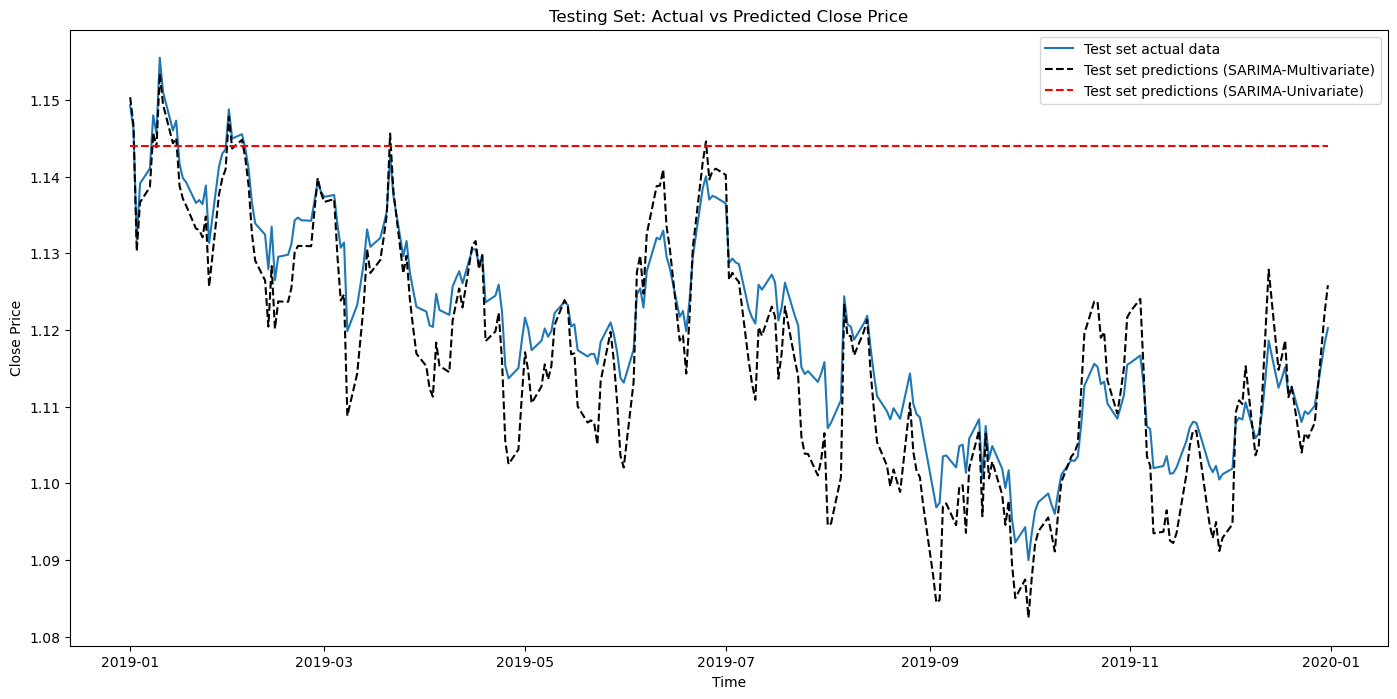

In [192]:
plt.figure(figsize=(17,8))
plt.plot(df_model_test['Close'], label=f'Test set actual data')
plt.plot(test_predictions_mm_1, 'k--', label=f'Test set predictions (SARIMA-Multivariate)')
plt.plot(test_predictions_1, 'r--', label=f'Test set predictions (SARIMA-Univariate)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Testing Set: Actual vs Predicted Close Price')
plt.legend()
plt.show()

It is obvious that compared to the univariate, the model is behaving much better and able to predict accurately some of the peaks. The model is following the behavior of the time series without any lags but at some points it is off.

Let's try the next approach:

#### Approach 2:

This time each time that one time step ahead is predicted the actual value of the present time stamp will be added to the model for the next prediction.

In [160]:
# Setup forecasts
nforecasts = 1
forecasts_mm = {}

# Save initial forecast
forecasts_mm[df_model_training.index[-1]] = res.forecast(steps=nforecasts, exog=train_data[indicator_variables.columns].iloc[[-1]])

# Step through the rest of the sample
for t in range(n_init_training, nobs):
    # Update the results by appending the next observation
    updated_df_model = df_mm['Close'].iloc[t:t+1]
    updated_df_model_exog = df_mm[indicator_variables.columns].iloc[t:t+1]
    res = res.append(updated_df_model, exog=updated_df_model_exog, refit=False)

    # Save the new set of forecasts
    forecasts_mm[updated_df_model.index[0]] = res.forecast(steps=nforecasts, exog=updated_df_model_exog)

# Combine all forecasts into a DataFrame
forecasts_mm = pd.concat(forecasts_mm, axis=1)

# Print the forecasts
print(forecasts_mm)


            2018-12-31  2019-01-01  2019-01-02  2019-01-03  2019-01-04   
2019-01-01    1.143995         NaN         NaN         NaN         NaN  \
2019-01-02         NaN    1.149306         NaN         NaN         NaN   
2019-01-03         NaN         NaN    1.146171         NaN         NaN   
2019-01-04         NaN         NaN         NaN    1.131811         NaN   
2019-01-07         NaN         NaN         NaN         NaN    1.139108   
...                ...         ...         ...         ...         ...   
2019-12-26         NaN         NaN         NaN         NaN         NaN   
2019-12-27         NaN         NaN         NaN         NaN         NaN   
2019-12-30         NaN         NaN         NaN         NaN         NaN   
2019-12-31         NaN         NaN         NaN         NaN         NaN   
2020-01-01         NaN         NaN         NaN         NaN         NaN   

            2019-01-07  2019-01-08  2019-01-09  2019-01-10  2019-01-11  ...   
2019-01-01         NaN         N

In [161]:
# Construct the forecast errors
forecast_errors_mm = forecasts_mm.apply(lambda column: df_mm['Close'] - column).reindex(forecasts_mm.index)

print(forecast_errors_mm.iloc[:5, :5])

            2018-12-31  2019-01-01  2019-01-02  2019-01-03  2019-01-04
2019-01-01    0.005311         NaN         NaN         NaN         NaN
2019-01-02         NaN   -0.003135         NaN         NaN         NaN
2019-01-03         NaN         NaN    -0.01436         NaN         NaN
2019-01-04         NaN         NaN         NaN    0.007297         NaN
2019-01-07         NaN         NaN         NaN         NaN    0.001936


In [162]:
# Reindex the forecasts by horizon rather than by date
def flatten(column):
    return column.dropna().reset_index(drop=True)

flattened_mm = forecast_errors_mm.apply(flatten)
flattened_mm.index = (flattened_mm.index + 1).rename('horizon')

print(flattened_mm.iloc[:3, :5])

         2018-12-31  2019-01-01  2019-01-02  2019-01-03  2019-01-04
horizon                                                            
1          0.005311   -0.003135    -0.01436    0.007297    0.001936


In [163]:
# Compute the root mean square error
rmse_mm = (flattened_mm**2).mean(axis=1)**0.5

print(rmse)

horizon
1    0.003616
dtype: float64


In [164]:
flattened_forecast_mm = forecasts_mm.apply(flatten)
flattened_forecast_mm

,2018-12-31,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,...,2019-12-18,2019-12-19,2019-12-20,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-30,2019-12-31
0,1.143995,1.149306,1.146171,1.131811,1.139108,1.141044,1.147974,1.145607,1.155495,1.151013,...,1.115138,1.111593,1.112595,1.107984,1.109385,1.109016,1.109545,1.110112,1.11823,1.12023


In [165]:
# To get the forecasts in a standard format
pred_test_mm = flattened_forecast_mm.loc[0,:]
pred_test_mm

2018-12-31    1.143995
2019-01-01    1.149306
2019-01-02    1.146171
2019-01-03    1.131811
2019-01-04    1.139108
                ...   
2019-12-25    1.109016
2019-12-26    1.109545
2019-12-27    1.110112
2019-12-30    1.118230
2019-12-31    1.120230
Name: 0, Length: 262, dtype: float64

In [166]:
# Remove the last prediction since it would be out of the range of the test data
test_predictions_mm_2 = pred_test_mm[:-1]

In [167]:
# Make the index of the predictions same as the actual test set for comparison
test_predictions_mm_2.index = df_mm[n_init_training:].index

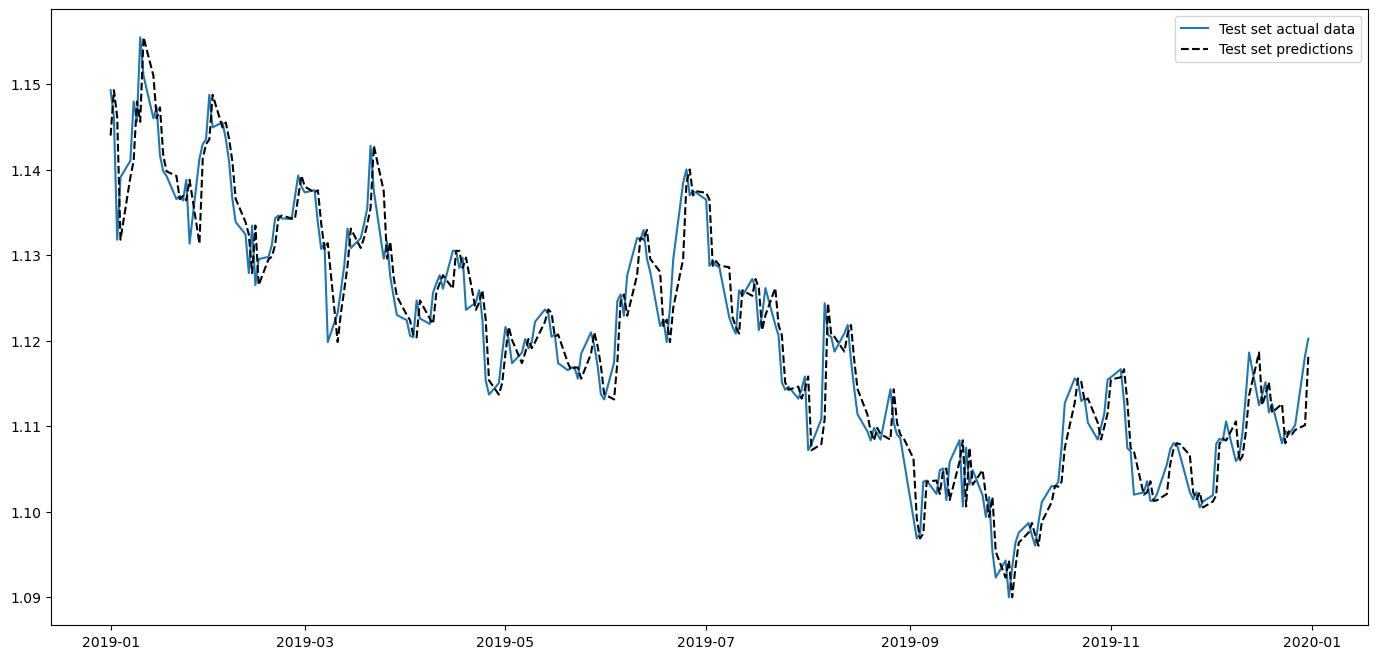

In [170]:
plt.figure(figsize=(17,8))
plt.plot(df_mm[n_init_training:]['Close'], label=f'Test set actual data')
plt.plot(test_predictions_mm_2, 'k--', label=f'Test set predictions')
plt.legend()
plt.show()

Again with this approach, the predictions are following exactly the actual data but with a lag which is coming from the differencing. 

## V. Performance Comparison

Based on the results found let's compare the results of the univariate and multivariate models. To have a better comparison of the models and to have a base performance for comparison with machine lerning techniques, the performance of the first approaches will be compared.

In [176]:
predictions = pd.DataFrame({
    'Univariate_model': test_predictions_1,
    'Multivariate_model': test_predictions_mm_1,
    'Actual_data': df_mm[n_init_training:]['Close'],
})
predictions

,Univariate_model,Multivariate_model,Actual_data
2019-01-01,1.143995,1.150345,1.149306
2019-01-02,1.143995,1.146752,1.146171
2019-01-03,1.143995,1.130286,1.131811
2019-01-04,1.143995,1.136634,1.139108
2019-01-07,1.143995,1.138621,1.141044
...,...,...,...
2019-12-25,1.143995,1.105893,1.109016
2019-12-26,1.143995,1.106912,1.109545
2019-12-27,1.143995,1.107868,1.110112
2019-12-30,1.143995,1.122201,1.118230


To comapre the performance of the models, the following metrics will be used:

- Root Mean Squared Error (RMSE): RMSE measures the standard deviation of the residuals, providing an estimate of the average magnitude of the prediction errors.

- Mean Absolute Percentage Error (MAPE): MAPE calculates the average percentage difference between the predicted values and the actual values, providing a relative measure of the magnitude of errors in the predictions.

- Nash-Sutcliffe Efficiency (NSE): NSE evaluates the predictive performance of a model by comparing the squared differences between the predicted and observed values to the squared differences between the observed values and their mean, with a value of 1 indicating a perfect fit.

In [189]:
# Calculate RMSE
mse_univariate = np.sqrt(((predictions['Actual_data'] - predictions['Univariate_model']) ** 2).mean())
mse_multivariate = np.sqrt(((predictions['Actual_data'] - predictions['Multivariate_model']) ** 2).mean())

# Calculate MAPE
mape_univariate = np.mean(np.abs((predictions['Actual_data'] - predictions['Univariate_model']) / predictions['Actual_data'])) * 100
mape_multivariate = np.mean(np.abs((predictions['Actual_data'] - predictions['Multivariate_model']) / predictions['Actual_data'])) * 100

# Calculate NSE
nse_univariate = 1 - np.sum((predictions['Univariate_model'] - predictions['Actual_data']) ** 2) / np.sum((predictions['Actual_data'] - np.mean(predictions['Actual_data'])) ** 2)
nse_multivariate = 1 - np.sum((predictions['Multivariate_model'] - predictions['Actual_data']) ** 2) / np.sum((predictions['Actual_data'] - np.mean(predictions['Actual_data'])) ** 2)


In [190]:
# Create a DataFrame for the metrics
metrics_df = pd.DataFrame({
    'RMSE': [rmse_univariate, rmse_multivariate],
    'MAPE': [mape_univariate, mape_multivariate],
    'NSE': [nse_univariate, nse_multivariate]
}, index=['Univariate Model', 'Multivariate Model'])

# Transpose the DataFrame
metrics_df = metrics_df.transpose()

metrics_df


,Univariate Model,Multivariate Model
RMSE,0.027748,0.005652
MAPE,2.203005,0.428069
NSE,-3.145579,0.828033


It can be observed that overall the mutivariate model is performing much better than the univariate model with a MAPE value of 0.428, indicating that on average, the model's predictions have an absolute percentage error of approximately 0.428%. 

These performances as base models will be compared to the machine learning models.